In [15]:
import numpy as np
import matplotlib.pyplot as plt

from utils import factor_model_solution, open_closed_data

*This notebook introduces the Akaike Information Criterion (AIC). The purpose of AIC is to choose the optimal k for factor analysis.*

___

# Akaike Information Criterion (AIC)

AIC is given by:
$$
AIC = 2 s_{params} - 2 \ln(\hat L)
$$

NOTE: $s_{params}$ is the number of estimated parameters in the model. $\hat L$ is the maximized value of the likelihood function.

$$
s_{params} = pk + p - \frac{1}{2}k(k - 1)
$$

and
$$
\ln (L) = -\frac{1}{2} n \log |2 \pi \Sigma | - \frac{1}{2} n \operatorname{tr} \Sigma^{-1} S 
$$

___

In [ ]:
def calculate_loglikelihood(specific_variance, X_data, k, standardized=True):
    """
    Calculate the factor model log likelihood objective function.

    Parameters
    ---
    specific_variance : (p,) arraylike
        The specific variances for each variable
    
    X_data : (n, p) arraylike

    k: float
        Number of factors

    standardized :       boolean
        Whether to use correlation matrix (standardized variables) or the covariance matrix
        in calculations.

    Returns
    ---
    Objective function value: float
    """
    n, p = X_data.shape

    # Step 1
    S = np.corrcoef(X_data.T) if standardized else np.cov(X_data.T)
    Psi = np.diag(specific_variance)
    Psi_sq_inv = np.linalg.inv(Psi ** 0.5)
    S_star = Psi_sq_inv @ S @ Psi_sq_inv

    # Step 2
    eigval, eigvec = np.linalg.eig(S_star)

    # Step 3
    lambda_star = []
    for i in range(k):
        lambda_star.append(max(eigval[i] - 1, 0) ** 0.5 * eigvec[:,i])
    lambda_star = np.array(lambda_star).T

    # Step 4
    lambda_hat = Psi ** 0.5 @ lambda_star

    # Step 5
    result = (
        - 1/2 * n * np.log(np.linalg.det(2 * np.pi * (lambda_hat @ lambda_hat.T + Psi)))
        - 1/2 * n * np.trace(np.linalg.inv(lambda_hat @ lambda_hat.T + Psi) @ S)
    )

    return result

def calculate_free_params(p, k):
    return p * k + p - 1/2 * k * (k - 1)

def AIC(k, X):
    n, p = X.shape
    psi_hat, _ = factor_model_solution(X, k)
    specific_variances = psi_hat[np.diag_indices_from(psi_hat)]
    return 2 * calculate_free_params(p, k) - 2 * calculate_loglikelihood(specific_variances, X, k)

In [7]:
X = open_closed_data()
X.shape

(88, 5)

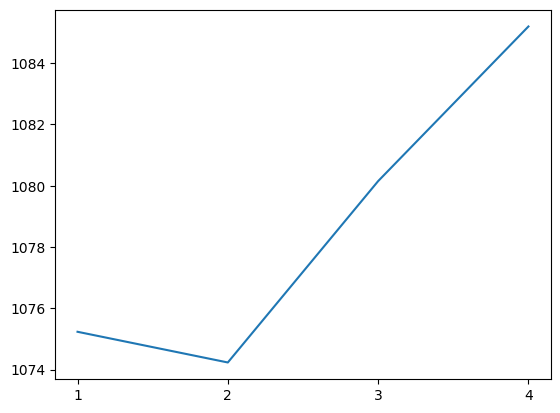

In [18]:
krange = range(1, X.shape[1])
AICs = [AIC(k, X) for k in krange]
plt.xticks(krange)
plt.plot(krange, AICs)